In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot
import os
from copy import deepcopy
from time import time
from math import ceil
from scipy.stats import spearmanr, gamma, poisson
import scib.metrics as me
import scib
from anndata import AnnData, read_h5ad
import anndata as ad
import scanpy as sc
from scanpy import read
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch import tensor
from torch.cuda import is_available
from sciPENN_API import sciPENN_API
import anndata as ad
from scipy.sparse import csr_matrix
import scipy.io as sio
import scipy

In [2]:
adata_gene = sc.read("final_rna.h5ad")
adata_protein = sc.read("final_adt.h5ad")

In [3]:
filter_bool = (((adata_gene.obs['donor'] == 'P1') & (adata_gene.obs['l1'] == 'B'))
                | ((adata_gene.obs['donor'] == 'P2') & (adata_gene.obs['l1'] == 'CD4 T'))
                | ((adata_gene.obs['donor'] == 'P3') & (adata_gene.obs['l1'] == 'CD8 T'))
                | ((adata_gene.obs['donor'] == 'P4') & (adata_gene.obs['l1'] == 'DC'))
                | ((adata_gene.obs['donor'] == 'P5') & (adata_gene.obs['l1'] == 'Mono'))
                | ((adata_gene.obs['donor'] == 'P6') & (adata_gene.obs['l1'] == 'NK'))
                | ((adata_gene.obs['donor'] == 'P7') & (adata_gene.obs['l1'] == 'other'))
                | ((adata_gene.obs['donor'] == 'P8') & (adata_gene.obs['l1'] == 'other T')))
adata_gene = adata_gene[np.invert(filter_bool)]
adata_protein = adata_protein[np.invert(filter_bool)]

In [7]:
train_bool1 = [x in [0] for x in adata_gene.obs['batch']]
train_bool2 = [x in [1] for x in adata_gene.obs['batch']]
train_bool3 = [x in [2] for x in adata_gene.obs['batch']]
train_bool4 = [x in [3] for x in adata_gene.obs['batch']]
train_bool5 = [x in [4] for x in adata_gene.obs['batch']]
train_bool6 = [x in [5] for x in adata_gene.obs['batch']]
train_bool7 = [x in [6] for x in adata_gene.obs['batch']]
train_bool8 = [x in [7] for x in adata_gene.obs['batch']]

adata_gene_set1 = adata_gene[train_bool1].copy()
adata_protein_set1 = adata_protein[train_bool1].copy()
adata_gene_set2 = adata_gene[train_bool2].copy()
adata_protein_set2 = adata_protein[train_bool2].copy()
adata_gene_set3 = adata_gene[train_bool3].copy()
adata_protein_set3 = adata_protein[train_bool3].copy()
adata_gene_set4 = adata_gene[train_bool4].copy()
adata_protein_set4 = adata_protein[train_bool4].copy()
adata_gene_set5 = adata_gene[train_bool5].copy()
adata_protein_set5 = adata_protein[train_bool5].copy()
adata_gene_set6 = adata_gene[train_bool6].copy()
adata_protein_set6 = adata_protein[train_bool6].copy()
adata_gene_set7 = adata_gene[train_bool7].copy()
adata_protein_set7 = adata_protein[train_bool7].copy()
adata_gene_set8 = adata_gene[train_bool8].copy()
adata_protein_set8 = adata_protein[train_bool8].copy()

In [8]:
train_label1 = [x in ['B'] for x in adata_gene_set1.obs['l1']]
train_label2 = [x in ['CD4 T'] for x in adata_gene_set2.obs['l1']]
train_label3 = [x in ['CD8 T'] for x in adata_gene_set3.obs['l1']]
train_label4 = [x in ['DC'] for x in adata_gene_set4.obs['l1']]
train_label5 = [x in ['Mono'] for x in adata_gene_set5.obs['l1']]
train_label6 = [x in ['NK'] for x in adata_gene_set6.obs['l1']]
train_label7 = [x in ['other'] for x in adata_gene_set7.obs['l1']]
train_label8 = [x in ['other T'] for x in adata_gene_set8.obs['l1']]

adata_gene_set1 = adata_gene_set1[np.invert(train_label1)].copy()
adata_protein_set1 = adata_protein_set1[np.invert(train_label1)].copy()
adata_gene_set2 = adata_gene_set2[np.invert(train_label2)].copy()
adata_protein_set2 = adata_protein_set2[np.invert(train_label2)].copy()
adata_gene_set3 = adata_gene_set3[np.invert(train_label3)].copy()
adata_protein_set3 = adata_protein_set3[np.invert(train_label3)].copy()
adata_gene_set4 = adata_gene_set4[np.invert(train_label4)].copy()
adata_protein_set4 = adata_protein_set4[np.invert(train_label4)].copy()
adata_gene_set5 = adata_gene_set5[np.invert(train_label5)].copy()
adata_protein_set5 = adata_protein_set5[np.invert(train_label5)].copy()
adata_gene_set6 = adata_gene_set6[np.invert(train_label6)].copy()
adata_protein_set6 = adata_protein_set6[np.invert(train_label6)].copy()
adata_gene_set7 = adata_gene_set7[np.invert(train_label7)].copy()
adata_protein_set7 = adata_protein_set7[np.invert(train_label7)].copy()
adata_gene_set8 = adata_gene_set8[np.invert(train_label8)].copy()
adata_protein_set8 = adata_protein_set8[np.invert(train_label8)].copy()

In [16]:
sciPENN = sciPENN_API(gene_trainsets = [adata_gene_set8], # Iteratively train adata_gene_set1 to adata_gene_set8
                        protein_trainsets = [adata_protein_set8], # Iteratively train adata_protein_set1 to adata_protein_set8 
                        train_batchkeys = ['donor'])
sciPENN.train(quantiles = [0.1, 0.25, 0.75, 0.9], n_epochs = 2000, ES_max = 12, decay_max = 6, decay_step = 0.1, 
              lr = 10**(-3), weights_dir = "transfer_INTEGRATE_label", load = True) # # Iteratively load trained weights

Searching for GPU
GPU detected, using GPU

Normalizing Training Cells

Log-Normalizing Training Data

Normalizing Gene Training Data by Batch


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 1/1 [00:00<00:00, 27.41it/s]


Epoch 0 prediction loss = 1.010
Epoch 1 prediction loss = 0.927
Epoch 2 prediction loss = 0.912
Epoch 3 prediction loss = 0.904
Epoch 4 prediction loss = 0.896
Epoch 5 prediction loss = 0.892
Epoch 6 prediction loss = 0.890
Epoch 7 prediction loss = 0.887
Epoch 8 prediction loss = 0.886
Epoch 9 prediction loss = 0.885
Epoch 10 prediction loss = 0.884
Epoch 11 prediction loss = 0.883
Epoch 12 prediction loss = 0.882
Epoch 13 prediction loss = 0.881
Epoch 14 prediction loss = 0.881
Decaying loss to 0.0001
Epoch 15 prediction loss = 0.880
Epoch 16 prediction loss = 0.880
Epoch 17 prediction loss = 0.880
Epoch 18 prediction loss = 0.879
Epoch 19 prediction loss = 0.879
Epoch 20 prediction loss = 0.879
Decaying loss to 1e-05
Epoch 21 prediction loss = 0.879
Epoch 22 prediction loss = 0.879
Epoch 23 prediction loss = 0.879
Epoch 24 prediction loss = 0.880
Epoch 25 prediction loss = 0.879
Epoch 26 prediction loss = 0.879
Decaying loss to 1.0000000000000002e-06
Epoch 27 prediction loss = 0.879

In [4]:
sciPENN = sciPENN_API(gene_trainsets = [adata_gene], 
                        protein_trainsets = [adata_protein], 
                        train_batchkeys = ['donor'])
sciPENN.train(quantiles = [0.1, 0.25, 0.75, 0.9], n_epochs = 2000, ES_max = 12, decay_max = 6, decay_step = 0.1, 
              lr = 10**(-3), weights_dir = "transfer_INTEGRATE_label", load = True)

Trying to set attribute `.obs` of view, copying.


Searching for GPU
GPU detected, using GPU


Trying to set attribute `.obs` of view, copying.



Normalizing Training Cells

Log-Normalizing Training Data

Normalizing Gene Training Data by Batch


100%|██████████| 8/8 [00:02<00:00,  3.37it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 8/8 [00:00<00:00, 28.66it/s]


Epoch 0 prediction loss = 1.042
Epoch 1 prediction loss = 1.042
Epoch 2 prediction loss = 1.042
Epoch 3 prediction loss = 1.042
Epoch 4 prediction loss = 1.042
Epoch 5 prediction loss = 1.042
Decaying loss to 0.0001


/root/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 6 prediction loss = 1.042
Epoch 7 prediction loss = 1.042
Epoch 8 prediction loss = 1.042
Epoch 9 prediction loss = 1.042
Epoch 10 prediction loss = 1.042
Epoch 11 prediction loss = 1.042
Decaying loss to 1e-05
Epoch 12 prediction loss = 1.042


In [6]:
embedding = sciPENN.embed()
embedding.write("transfer_label.h5ad")

... storing 'batch' as categorical
... storing 'Dataset' as categorical


In [7]:
df = pd.DataFrame(embedding.X)
df.to_csv("scipenn_transfer.csv", sep=',', index=False, header=False)

2023-09-15 03:38:06.623020: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


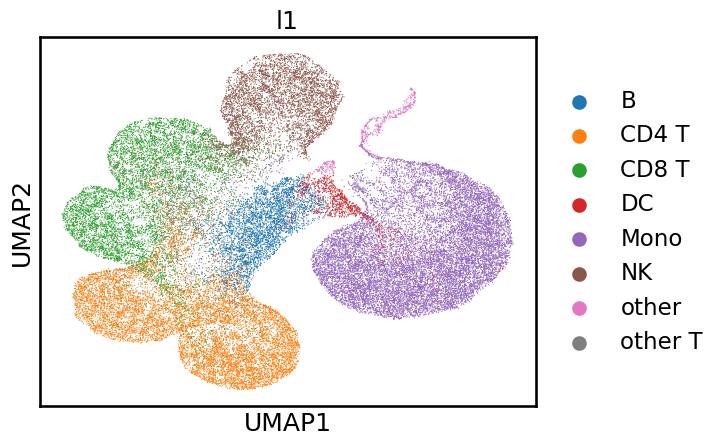

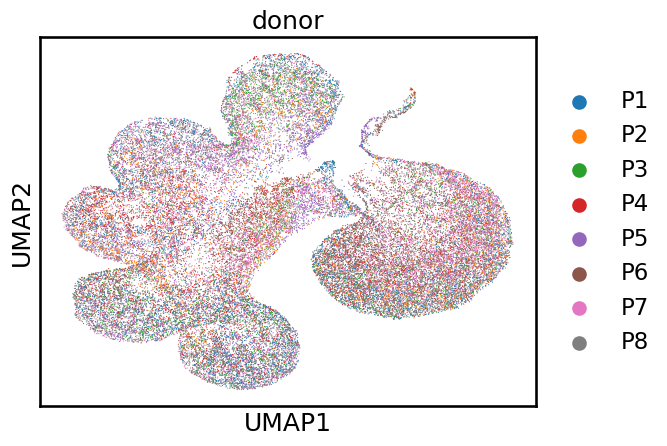

In [8]:
scipenn_embedding = sc.read('transfer_label.h5ad')
view = scipenn_embedding[np.random.choice(scipenn_embedding.n_obs, scipenn_embedding.n_obs, replace=False)]
new = sc.pp.subsample(scipenn_embedding, fraction=1, copy=True)
sc.pp.neighbors(new, n_pcs = 20)
sc.tl.umap(new)
sc.pl.umap(new, color='l1', save='scipenn_rna+adt_transfer_label_integration_celltype.png', sort_order=False)
sc.pl.umap(new, color='donor', save='scipenn_rna+adt_transfer_label_integration_donor.png', sort_order=False)